# Laboratório #4

### Instruções

1. Antes de começar, você deve clicar na opção "Copiar para o Drive" na barra superior do Colab. Depois de clicar nela, verifique se você está trabalhando nessa versão do notebook para que seu trabalho seja salvo.
2. Quando você terminar os exercícios do laboratório, vá ao menu do Colab ou Jupyter e selecione a opção para fazer download do notebook.
    * Os notebooks tem extensão .ipynb. 
    * Este deve ser o arquivo que você irá entregar.
    * No Colab vá até a opção **File** -> **Download .ipynb**.
    * No Jupyter vá até a opção **File** -> **Download as** -> **Notebook (.ipynb)**.
3. Após o download do notebook, vá até a aba de tarefas do MS Teams, localize a tarefa referente a este laboratório e faça o upload do seu notebook. Veja que há uma opção de anexar arquivos à tarefa.
4. Não se esqueça de colocar seu **nome** e **matrícula** na célula de texto abaixo.

**Nome**:

**Matrícula**:

## Exercícios

### 1)  Neste exercício, você irá analisar o desempenho do algoritmo do gradiente descendente para alguns valores do passo de aprendizagem.

O código da célula abaixo, além de conter a definição de algumas funções que iremos utilizar neste exercício, gera valores da seguinte **função observável**

$$y_{noisy} = y + w,$$

onde $w$ é vetor coluna com $N = 1000$ (ou seja, o número de exemplos) valores retirados de uma distribuição aleatória Gaussiana Normal Padrão (i.e., com média zero e variância unitária) e $y$ é vetor com valores da **função objetivo**. Neste exercício, a **função objetivo** (ou **modelo gerador**) é dada por:

$$y = x_1 + x_2,$$

onde $x_1$ e $x_2$ são vetores coluna com $N$ valores retirados da distribuição Gaussiana Normal Padrão.

A **função hipótese** para este exercício é dada por

$$h = \hat{a}_1 x_1 + \hat{a}_2 x_2.$$

De posse destas informações, faça o seguinte:

#### A. Execute a célula de código abaixo e analise a definição da função `gradientDescentMiniBatch`. Como o próprio nome da função sugere, utilizamos a versão em mini-batches do gradiente descendente (GD).

**DICA**:

+ Além de definir algumas funções que serão utilizadas ao longo do exercício, a célula abaixo gera o conjunto amostras de treinamento.
+ A execução da célula abaixo pode levar um certo tempo, pois ela baixa um arquivo do repositório github da disciplina.

In [7]:
# Import all necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
import random
import urllib
# Retrieve script with results.
url = 'https://raw.githubusercontent.com/zz4fap/t319_aprendizado_de_maquina/main/labs/results.py'
urllib.request.urlretrieve(url, filename='./results.py')
import results as r

# Reset the pseudo random number generator to the same value.
seed = 42
np.random.seed(seed)
random.seed(seed)

# Generate points for plotting the error surface.
def calculateErrorSurface(X, y):
    '''
    Função que calcula os pontos para plotar a superfície de erro.
    Parâmetros de entrada:
        X: matriz de atributos
        y: vetor de rótulos (ou valores esperados)
    Retorno:
        J: matriz com os erros para os pontos de A1 e A2.
        A1: matriz com valores do peso a1.
        A2: matriz com valores do peso a2.
    '''
    # Retrieve the number of samples.
    N = len(y)
    # Generate values for parameters.
    M = 200
    a1 = np.linspace(-20.0, 24.0, M)
    a2 = np.linspace(-20.0, 24.0, M)

    A1, A2 = np.meshgrid(a1, a2)

    # Generate points for plotting the cost-function surface.
    J = np.zeros((M,M))
    for iter1 in range(0, M):
        for iter2 in range(0, M):
            yhat = A1[iter1, iter2]*x1 + A2[iter1, iter2]*x2
            J[iter1, iter2] = (1.0/N)*np.sum(np.square(y - yhat))
    return J, A1, A2

# Closed-form solution.
def normalEquationSolution(X, y):
    '''
    Função que calcula os valores ótimos dos pesos com a equação normal.
    Parâmetros de entrada:
        X: matriz de atributos
        y: vetor de rótulos (ou valores esperados)
    Retorno:
        a_opt: vetor com os pesos ótimos
        Joptimum: erro quadrático médio obtido com o vetor de pesos ótimos.
    '''
    N = len(y)
    a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y))
    yhat = X.dot(a_opt)
    Joptimum = (1.0/N)*np.sum(np.power((y - yhat), 2))
    return a_opt, Joptimum

# Gradient descent solution.
def gradientDescentMiniBatch(X, y, alpha, n_epochs, mb_size, seed):
    '''
    Função que implementa a versão em mini-lotes do algoritmo do gradiente descendente.
    Parâmetros de entrada:
       X: matriz de atributos
       y: vetor de rótulos (ou valores esperados)
       alpha: valor do passo de aprendizagem
       n_epochs: número máximo de épocas
       mb_size: tamanho do mini-batch
       seed: semente usada para resetar o gerador aleatório
    Retorno:
        a: vetor de pesos encontrados pelo gradiente descendente
        Jgd: vetor de erros
        a_hist: vetor com o histórico das atualizações dos pesos
        grad_hist: vetor com o histórico das atualizações dos gradientes
        inc: valor da última iteração
    '''    
    # Extract the number of examples from y.
    N = len(y)
    
    # Reset PN generator.
    random.seed(seed)
    
    # Random initialization of parameters.
    a = np.array([-20.0, -20.0]).reshape(2, 1)

    # Create vector for parameter history.
    a_hist = np.zeros((2, n_epochs*(N//mb_size)+1))
    # Initialize history vector.
    a_hist[:, 0] = a.reshape(2,)

    # Create array for storing error values.
    Jgd = np.zeros(n_epochs*(N//mb_size)+1)

    Jgd[0] = (1.0/N)*sum(np.power(y - X.dot(a), 2))

    # Create array for storing gradient values.
    grad_hist = np.zeros((2, n_epochs*(N//mb_size)))

    # Gradient-descent loop.
    inc = 0
    for epoch in range(n_epochs):

        # Shuffle the whole dataset before every epoch.
        shuffled_indexes = random.sample(range(0, N), N)
        
        # Iterate over the iterations, one mini-batch at a time.
        for i in range(0, N//mb_size):

            # Selecting a mini-batch.
            start = i*mb_size
            end = mb_size*(i+1)
            indexes = shuffled_indexes[start:end]

            # Pick the samples composing the mini-batch.
            xi = X[indexes]
            yi = y[indexes]

            # Calculate the gradient approximation.
            gradients = -(2.0/mb_size)*xi.T.dot(yi - xi.dot(a))
            
            # Weights' update. 
            a = a - alpha*gradients

            # Calculate per iteration error.
            Jgd[inc+1] = (1.0/N)*sum(np.power((y - X.dot(a)), 2))

            # Store history.
            grad_hist[:, inc] = gradients.reshape(2,)
            a_hist[:, inc+1] = a.reshape(2,)

            # Increment the iteration counter.
            inc += 1
            
    return a, Jgd, a_hist, grad_hist, inc

# Number of examples
N = 1000

# Input values (features)
x1 = np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# True model.
y = x1 + x2

# Observable function.
y_noisy = y + w

# Concatenate both feature vectors to create the attribute matrix.
X = np.c_[x1, x2]

# Generate values for plotting the error surface.
J, A1, A2 = calculateErrorSurface(X, y_noisy)

# Calculate optimum parameters with closed-form.
a_opt, Joptimum = normalEquationSolution(X, y_noisy)

#### B. Execute a célula de código abaixo e analise os resultados apresentados. Em seguida, responda as seguintes questões:
1. O que você pode dizer sobre o valor escolhido para o passo de aprendizagem? 
2. O que pode ser feito para melhorar o desempenho neste caso?

**DICA**:
* Verifique o número de iterações necessárias para que o algoritmo se aproxime do mínimo global.
* A figura menor dentro da figura com o erro em função das épocas mostra os resultados apenas das primeiras 500 épocas.

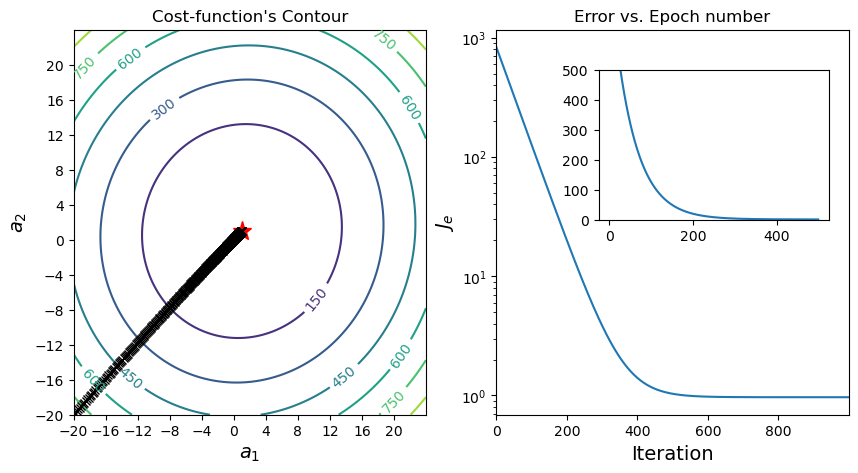

In [8]:
# Number of epochs.
numOfEpochs = 1000

# Learning rate.
alpha = 0.005

# Find solution to the linear regression problem with the gradient descent.
a, Jgd, a_hist, grad_hist, iteration = gradientDescentMiniBatch(X, y_noisy, alpha, numOfEpochs, N, seed)

# Plot results.
r.plotResults(Jgd, J, A1, A2, a_opt, a_hist, iteration, 500, 500)

<span style="color:blue">Escreva abaixo sua análise sobre o que está ocorrendo nos resultados acima.</span>

* Respostas:


#### C. Execute a célula de código abaixo e analise os resultados apresentados. Em seguida, responda as seguintes questões:
1. O que você pode dizer sobre o valor escolhido para o passo de aprendizagem? 
2. O que pode ser feito para melhorar o desempenho neste caso?

**DICAS**:
+ Sabendo que o vetor de pesos é inicializado com os valores $a_1 = -20$ e $a_2 = -20$, verifique a trajetoria das atualizações dos pesos. O algoritmo vai diretamente para o ponto de mínimo global como no exercício anterior?
+ O valor do erro diminui até que se torne constante como no exercício anterior?
+ A figura menor dentro da figura com o erro em função das épocas mostra os resultados apenas das primeiras 200 épocas.

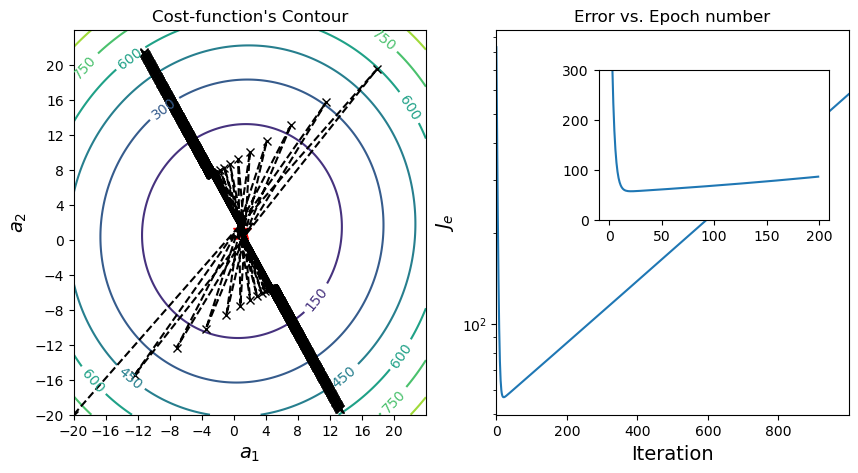

In [3]:
# Number of epochs.
numOfEpochs = 1000

# Learning rate.
alpha = 0.9793

# Find solution to the linear regression problem with the gradient descent.
a, Jgd, a_hist, grad_hist, iteration = gradientDescentMiniBatch(X, y_noisy, alpha, numOfEpochs, N, seed)

# Plot results.
r.plotResults(Jgd, J, A1, A2, a_opt, a_hist, iteration, 200, 300)

<span style="color:blue">Escreva abaixo sua análise sobre o que está ocorrendo nos resultados acima.</span>

* Respostas:


#### D. Execute a célula de código abaixo e analise os resultados apresentados. Em seguida, responda as seguintes questões:
1. O que você pode dizer sobre o valor escolhido para o passo de aprendizagem? 
2. O que pode ser feito para melhorar o desempenho neste caso?

**DICAS**:
+ Sabendo que o vetor de pesos é inicializado com os valores $a_1 = -20$ e $a_2 = -20$, verifique a trajetoria das atualizações dos pesos. O algoritmo vai diretamente para o ponto de mínimo global?
+ Verifique o número de iterações necessárias para que o algoritmo se aproxime do ponto de mínimo global.
+ O valor do erro diminui até que se torne constante?
+ A figura menor dentro da figura com o erro em função das épocas mostra os resultados apenas das primeiras 4 épocas.

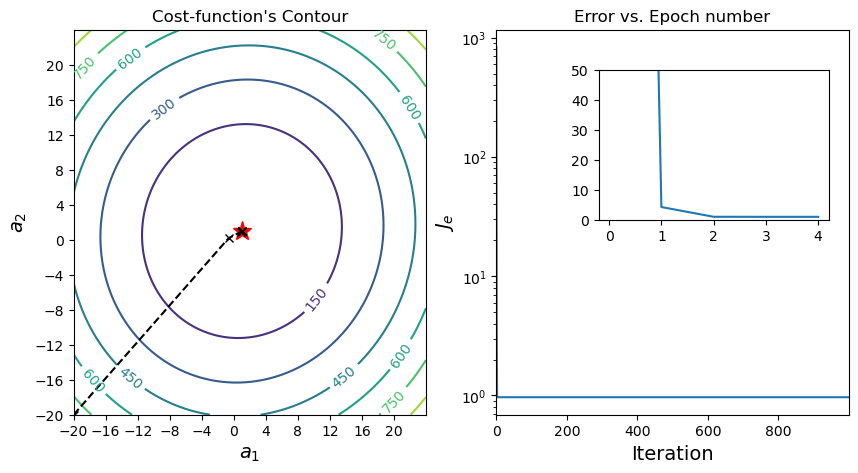

In [9]:
# Number of epochs.
numOfEpochs = 1000

# Learning rate.
alpha = 0.5

# Find solution to the linear regression problem with the gradient descent.
a, Jgd, a_hist, grad_hist, iteration = gradientDescentMiniBatch(X, y_noisy, alpha, numOfEpochs, N, seed)

# Plot results.
r.plotResults(Jgd, J, A1, A2, a_opt, a_hist, iteration, 5, 50)

<span style="color:blue">Escreva abaixo sua análise sobre o que está ocorrendo nos resultados acima.</span>

* Respostas:


### 2) Neste exercício, você irá analisar o desempenho do algoritmo do gradiente descendente estocástico (GDE) sem e com redução do passo de aprendizagem. Utilizaremos as mesmas funções **observável** e **hipótese** do exercício anterior.

#### A. Execute a célula de código abaixo e analise a definição da função `gradientDescentLearningRateDecay`. Observe que utilizamos novamente a versão em mini-batches do GD, porém, desta vez, temos também a adição de um esquema de redução do passo de aprendizagem.

In [13]:
import math as m

# Gradient descent solution.
def gradientDescentLearningRateDecay(X, y, alpha_init, n_epochs, mb_size, lrd, seed):
    '''
    Função que implementa o algoritmo do gradiente descendente.
    Parâmetros de entrada:
       X: matriz de atributos
       y: vetor de rótulos (ou valores esperados)
       alpha_init: valor inicial do passo de aprendizagem
       n_epochs: número máximo de épocas
       mb_size: tamanho do mini-batch
       lrd: tipo de redução do passo de aprendizagem (learning rate decay)
       seed: semente usada para resetar o gerador aleatório
    Retorno:
        a: vetor de pesos encontrados pelo gradiente descendente
        Jgd: vetor de erros
        a_hist: vetor com o histórico das atualizações dos pesos
        grad_hist: vetor com o histórico das atualizações dos gradientes
        alpha_hist: vetor com o histórico das atualizações do passo de aprendizagem
        inc: valor da última iteração       
    '''    
    # Retrieve the number of examples from y.
    N = len(y)
    
    # Reset PN generator.
    random.seed(seed)
    
    # Random initialization of parameters.
    a = np.array([-20.0, -20.0]).reshape(2, 1)

    # Create vector for parameter history.
    a_hist = np.zeros((2, n_epochs*(N//mb_size)+1))
    # Initialize history vector.
    a_hist[:, 0] = a.reshape(2,)

    # Create array for storing error values.
    Jgd = np.zeros(n_epochs*(N//mb_size)+1)

    Jgd[0] = (1.0/N)*sum(np.power(y - X.dot(a), 2))

    # Create array for storing gradient values.
    grad_hist = np.zeros((2, n_epochs*(N//mb_size)))
    
    # Create array for storing past alpha values.
    alpha_hist = np.zeros((n_epochs*(N//mb_size),))

    # Gradient-descent loop.
    inc = 0
    for e in range(n_epochs):

        # Shuffle the whole dataset before every epoch.
        shuffled_indexes = random.sample(range(0, N), N)
        
        # Iterate over the iterations, one mini-batch at a time.
        for i in range(0, N//mb_size):

            # Selecting a mini-batch.
            start = i*mb_size
            end = mb_size*(i+1)
            indexes = shuffled_indexes[start:end]

            # Pick the samples composing the mini-batch.
            xi = X[indexes]
            yi = y[indexes]
            
            # Update the learning rate.
            alpha = learningDecay(lrd, alpha_init, inc)
        
            # Calculate the gradient approximation.
            gradient = -(2.0/mb_size)*xi.T.dot(yi - xi.dot(a))
            
            # Weight's update.
            update = alpha*gradient
            a = a - update

            # Calculate per iteration error.
            Jgd[inc+1] = (1.0/N)*sum(np.power((y - X.dot(a)), 2))

            # Store history.
            grad_hist[:, inc] = gradient.reshape(2,)
            a_hist[:, inc+1] = a.reshape(2,)
            
            # Store alpha's history.
            alpha_hist[inc] = alpha

            # Iteration increment.
            inc += 1
            
    return a, Jgd, a_hist, grad_hist, alpha_hist, inc

# learning decay: Gradual decay.
def stepDecay(alpha_init, t, beta=15.0, drop=0.5):
    alpha = alpha_init * m.pow(drop, m.floor((1+t)/beta))
    return alpha

def learningDecay(lrd, alpha_init, t):
    alpha = alpha_init
    if(lrd == 'step'):
        alpha = stepDecay(alpha_init, t)
    return alpha

#### B. Execute a célula de código abaixo e analise os resultados apresentados. Em seguida, responda as seguintes questões:
1. O passo de aprendizagem é fixo ou está sendo reduzido a cada iteração do algoritmo?
2. O algoritmo converge e se estabiliza no ponto de mínimo global?
3. Podemos dizer que o GDE utiliza uma aproximação ruidosa do gradiente?

**DICAS**:

* Para responder a questão 1 deste item, verifique o gráfico que mostra o valor do passo de aprendizagem, $\alpha$, a cada iteração do algoritmo do gradiente descendente estocástico.
* Para responder as questões 2 e 3 deste item, analise os resultados mostrados nas figuras *Cost-function's Contour* e *Error vs. Epoch number* apresentadas abaixo.

**OBS.**:

+ Perceba que o tamanho do mini-batch passado para a função é igual a 1, indicando que a versão a ser utilizada pelo gradiente descendente é a estocástica.

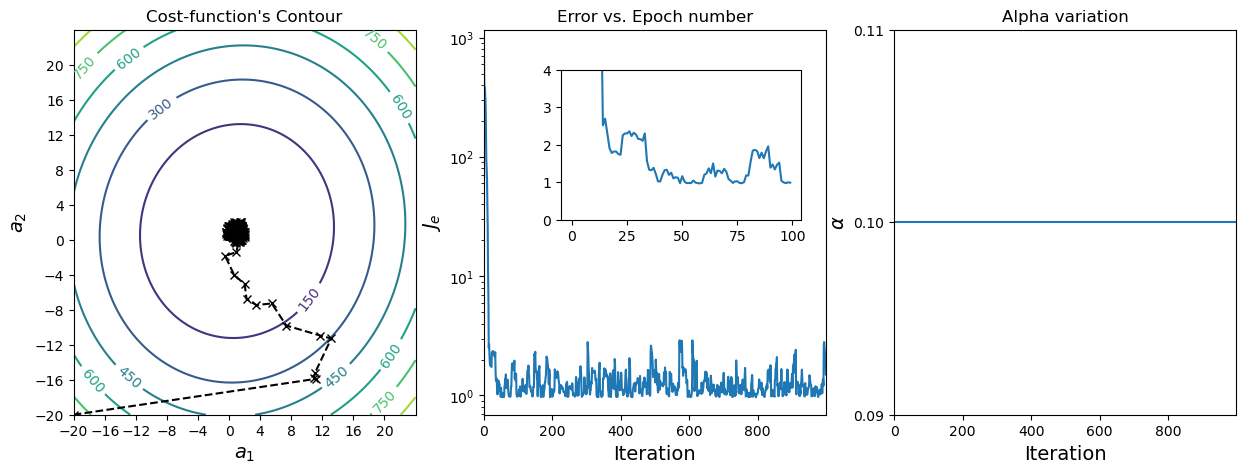

In [16]:
# Number of epochs.
numOfEpochs = 1

# Initial learning rate.
alpha_init = 0.1

# Mini-batch size.
mb_size = 1

# Find solution to the linear regression problem with the gradient descent.
a, Jgd, a_hist, grad_hist, alpha_hist, iteration = gradientDescentLearningRateDecay(X, y_noisy, alpha_init, numOfEpochs, mb_size, 'none', seed)

# Plot results.
r.plotResults2(Jgd, J, A1, A2, a_opt, a_hist, alpha_hist, iteration, 100, 4)

<span style="color:blue">Escreva abaixo sua respostas.</span>

* Respostas:


#### C. Execute a célula de código abaixo e analise os resultados apresentados. Em seguida, responda as seguintes questões:
1. O passo de aprendizagem é fixo ou está sendo reduzido a cada iteração do algoritmo? 
2. Qual estratégia de **redução programada** está sendo utilizada neste exercício?
3. O algoritmo converge e se estabiliza no ponto de mínimo global?
4. Se o GDE usa uma aproximação ruidosa do vetor gradiente, como foi possível que ele se estabilizasse no ponto de mínimo global?
5. Qual é o número de iterações, $\beta$, usado no exercício para se reduzir o passo de aprendizagem, ou seja, após quantas iterações o valor de $\alpha$ é reduzido?
6. Qual é o fator, $\tau$, utilizado para se reduzir o passo de aprendizagem, ou seja, de quanto $\alpha$ é reduzido?

**DICAS**:

* Para responder à questão 1 deste item, verifique o gráfico que mostra o valor de $\alpha$ a cada iteração do algoritmo do gradiente descendente estocástico.
* Para responder à questão 2 deste item, analise o código do item **A** e a figura com a variação de $\alpha$ em função das iterações.
* Para responder à questão 3 deste item, analise os resultados mostrados nas figuras *Cost-function's Contour* e *Error vs. Epoch number* apresentadas abaixo.
* Para responder à questão 4 deste item, analise os resultados mostrados nas figuras *Error vs. Epoch number* e *Alpha variation* apresentadas abaixo.
* Para responder às questões 5 e 6 deste item, analise o resultado mostrado na figura *Alpha variation* apresentada abaixo. Veja a figura onde se tem um **zoom** das primeiras 30 iterações do algoritmo. Você também pode analisar o código do item **A** para responder as questões 5 e 6.

**OBS.**:

+ Perceba que o tamanho do mini-batch passado para a função é igual a 1, indicando que a versão a ser utilizada pelo gradiente descendente é a estocástica.

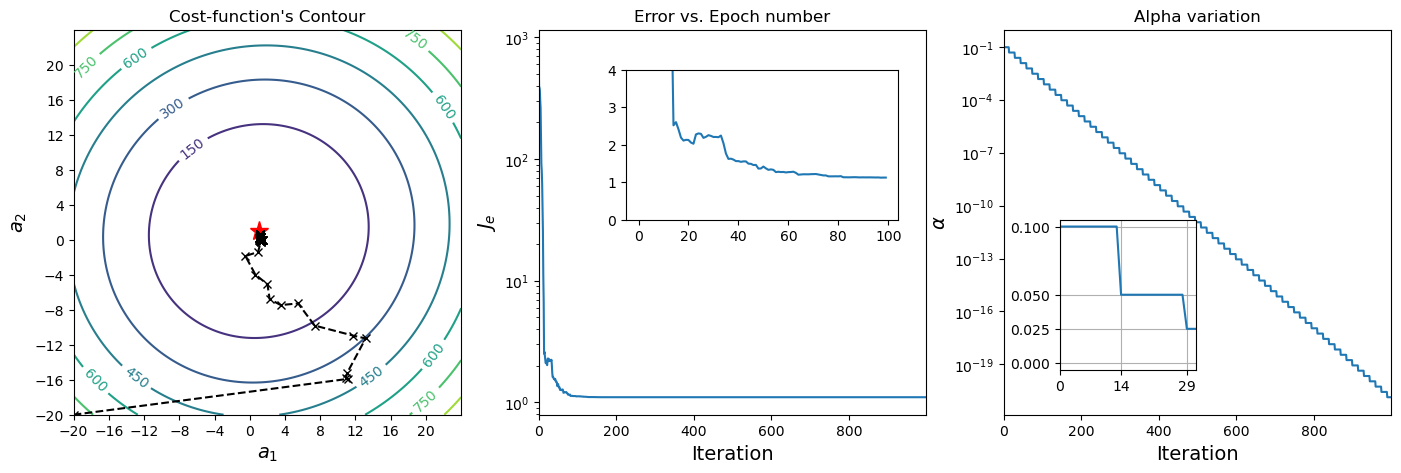

In [15]:
# Number of epochs.
numOfEpochs = 1

# Initial learning rate.
alpha_init = 0.1

# Mini-batch size.
mb_size = 1

# Find solution to the linear regression problem with the gradient descent.
a, Jgd, a_hist, grad_hist, alpha_hist, iteration = gradientDescentLearningRateDecay(X, y_noisy, alpha_init, numOfEpochs, mb_size, 'step', seed)

# Plot results.
r.plotResults3(Jgd, J, A1, A2, a_opt, a_hist, alpha_hist, iteration, 100, 4)

<span style="color:blue">Escreva abaixo sua respostas.</span>

* Respostas:
